# Emotions Recognition

Udacity Nanodegre Capstone Project

## Basic Data Research

First of all, let's look into available data structure and sample some examples.

In [5]:
from IPython.display import display
from basedir import data
import pandas as pd


emotions_data = pd.read_csv(data('fer2013', 'fer2013.csv'))
emotions_data['emotion'] = emotions_data['emotion'].apply(int)
emotions_data.head(3)

In [3]:
def get_subset(labels):
    if isinstance(labels, str):
        labels = [labels]
    return pd.DataFrame(emotions_data[emotions_data.Usage.isin(labels)])


training_data = get_subset(['Training', 'PublicTest'])
del training_data['Usage']

test_data = get_subset('PrivateTest')
del test_data['Usage']

In [8]:
%matplotlib inline
from itertools import chain
import random

import matplotlib.pylab as plt
import numpy as np


verbose_emotion = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


def to_image(data, size=48):
    if isinstance(data, str):
        data = data.split()
    flat = np.array([float(px) for px in data])
    return flat.reshape((size, size))


def sample_emotions(emotions=None):
    grid_spec = {'hspace': 0.5}
    fig, axes = plt.subplots(4, 4, figsize=(8, 8), facecolor='whitesmoke', gridspec_kw=grid_spec)
    df = training_data
    n = len(df)

    if emotions is not None:
        emotions = list(
            i for i, name in enumerate(verbose_emotion)
            if name.lower() in emotions)
        df = df[df.emotion.isin(emotions)]

    # color_map = plt.cm.get_cmap('Greys')
    color_map = plt.cm.get_cmap('coolwarm')

    for ax in chain(*axes):
        record = df.iloc[random.randint(0, n)]
        img = to_image(record.pixels)
        ax.imshow(img, cmap=color_map)
        ax.set_title("Emotion = '%s'" % verbose_emotion[record.emotion],
                     fontdict={'fontsize': 10})
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.savefig("/Users/ck/Desktop/faces.png", format='png')


sample_emotions()

In [24]:
from collections import Counter
from operator import itemgetter

counter = Counter(emotions_data.emotion.tolist())
pairs = sorted(counter.items(), key=itemgetter(0))
verbose = [{"label": i, "verbose": verbose_emotion[i], "count": count}  
           for i, count in pairs]

df = pd.DataFrame(verbose)
print("Emotions set")
display(df)

Emotions set


,count,label,verbose
0,4953,0,Angry
1,547,1,Disgust
2,5121,2,Fear
3,8989,3,Happy
4,6077,4,Sad
5,4002,5,Surprise
6,6198,6,Neutral


## More Involved Analysis and Data Transformation

First steps worked with original data file and don't alternate it in any way. To make the original data more suitable for next steps, a few modifications were applied.

Also, as soon as the dataset was excluded from repository (because of its big size), an extra utility was created to download this data. Thereofore, the first step is to download, preapre and dump processed data to make it available for next steps. Global configuration and misc parameters are also set in the next cell.

In [57]:
import os
import glob
import logging
import logging.config

import numpy as np
import pandas as pd
from IPython.display import display

from basedir import DATA_FOLDER, data
from emotions import Dataset, dump, load
from utils import sample_images, plot_learning_curve


# Notebook configuration. Next cells could use these values to contol code flow 
DEBUG = True
LOGGING_CONFIG = {
    'version': 1,
    'disable_existing_loggers': True,
    'formatters': {
        'console': {
            'format': '[%(asctime)s] %(name)s: %(message)s'            
        }
    },
    'handlers': {
        'stream': {
            'level': 'DEBUG',
            'formatter': 'console',
            'class': 'logging.StreamHandler',
        }
    },
    'loggers': {
        'notebook': {
            'handlers': ['stream'],
            'level': logging.DEBUG if DEBUG else logging.INFO,
            'propagate': False            
        }
    }
}
RANDOM_STATE = 1
SUBSET_INDEX = 0 if DEBUG else None
N_FOLDS = 10

# Data configuration
IMAGE_SIZE = 48
FALLBACK_VALUE = DATA_FOLDER
DATA_FOLDER = os.environ.get('DATA_FOLDER', FALLBACK_VALUE)
assert DATA_FOLDER, "DATA_FOLDER env variable is not set. Set variable or provide fallback value"

# Setup logging
logging.config.dictConfig(LOGGING_CONFIG)
log = logging.getLogger('notebook')

In [1]:
filenames = list(glob.glob1(DATA_FOLDER, '*.npy'))
loader = Dataset('fer2013', dataset_folder=DATA_FOLDER)

if not filenames:
    log.info("Data files not found. Loading dataset..")
    url = 'https://www.dropbox.com/s/jrivrub0ii16s4h/fer2013.tar.gz?dl=1'
    loader.load_from_url(url, archive=True, name_in_archive='fer2013/fer2013.csv')

    log.info("Preparing dataset for processing..")
    loader.prepare()
    df = loader.prepared
    X = df.drop(['label', 'verbose', 'subset'], axis=1).values
    y = df.label.values
    split_config = {'shuffle': True, 'random_state': RANDOM_STATE}

    log.info("Dump dataset into smaller chunks..")

    # save data splitted into chunks
    dump(X, y, prefix='emotions', output_dir=DATA_FOLDER, folds=N_FOLDS, stratified=True, **split_config)
    filenames = list(glob.glob1(DATA_FOLDER, '*.npy'))
    assert len(filenames) > 0, "Data loader invoked, but data not found"

    log.info("File created in %s:", DATA_FOLDER)
    for filename in filenames:
        log.info(".. %s", filename)
    log.info("Done!")
            

if DEBUG:
    log.warning("You're in DEBUG mode - only a subset of data will be used")

X, y = load(DATA_FOLDER, prefix='emotions', subset_index=SUBSET_INDEX)
log.info("Dataset shape: X=%s, y=%s" % (str(X.shape), str(y.shape)))  
log.info("Images sample to verify that dataset wasn't malformed")
fig, _ = sample_images(X, img_size=IMAGE_SIZE)
display(fig)

NameError: name 'glob' is not defined

Next step is data normalization and splitting into test and train subsets. 

> **Note**: Dependting on applied model, extra preprocessing steps could be applied (like reformating images into squeare matrices before applyied CNN, feature selection for linear models, etc.)

[2017-01-10 08:18:13,917] notebook: Images sample after Min-Max normalization


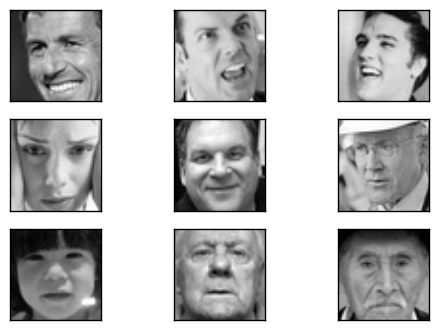

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, random_state=RANDOM_STATE, test_size=0.1)

log.info("Images sample after Min-Max normalization")
fig, _ = sample_images(X_train, img_size=IMAGE_SIZE)
display(fig)

---
### Baseline models

To have a basic threshold to estimate deep learning model performence, the following baseline estimators were chosen:
1. Multiclass Logistic Regression (one-vs-all approach)
2. Random Forest Classifier

### Logistic regression

The first applyied model is Logistic Regression Classifier. To select the most optimal model, grid search is applied. The varying parameters are `penalty` (regularization norm) and `C` (reqularization multiplier, i.e. $\frac{1}_{\lambda}$).

In [11]:
from operator import itemgetter

from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV


param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [100.0, 30.0, 10.0, 3.0, 1.0]
}

logreg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)        
log.info("Selected baseline model: %s", str(logreg.__class__.__name__))
grid_search = GridSearchCV(estimator=logreg, cv=5, param_grid=param_grid, n_jobs=-1, verbose=2)
_ = grid_search.fit(X_train, y_train.ravel())

[2017-01-09 13:17:19,730] notebook: Selected baseline model: LogisticRegression


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=100.0, penalty=l1 .............................................
[CV] C=100.0, penalty=l1 .............................................
[CV] C=100.0, penalty=l1 .............................................
[CV] C=100.0, penalty=l1 .............................................
[CV] C=100.0, penalty=l1 .............................................
[CV] C=100.0, penalty=l2 .............................................
[CV] C=100.0, penalty=l2 .............................................
[CV] C=100.0, penalty=l2 .............................................
[CV] .............................. C=100.0, penalty=l2, total= 2.1min
[CV] C=100.0, penalty=l2 .............................................
[CV] .............................. C=100.0, penalty=l2, total= 2.1min
[CV] C=100.0, penalty=l2 .............................................
[CV] .............................. C=100.0, penalty=l2, total= 2.1min
[CV] C=30.0, pen

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.9min


[CV] ............................... C=10.0, penalty=l2, total= 1.5min
[CV] C=3.0, penalty=l1 ...............................................
[CV] ............................... C=10.0, penalty=l1, total= 4.1min
[CV] C=3.0, penalty=l1 ...............................................
[CV] ............................... C=10.0, penalty=l2, total= 1.6min
[CV] C=3.0, penalty=l2 ...............................................
[CV] ............................... C=10.0, penalty=l1, total= 4.1min
[CV] C=3.0, penalty=l2 ...............................................
[CV] ................................ C=3.0, penalty=l1, total= 1.9min
[CV] C=3.0, penalty=l2 ...............................................
[CV] ................................ C=3.0, penalty=l1, total= 1.8min
[CV] C=3.0, penalty=l2 ...............................................
[CV] ............................... C=10.0, penalty=l1, total= 4.4min
[CV] C=3.0, penalty=l2 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.5min finished


Next cell shows validation results along with the best parameters.

In [12]:
best_logreg = grid_search.best_estimator_
best_logreg_params = grid_search.best_params_
logreg_cv_results = grid_search.cv_results_
param_cols = [c for c in logreg_cv_results.keys()
              if c.startswith('param_')]

columns_of_interest = [
    'mean_fit_time', 
    'mean_train_score', 'std_train_score',
    'mean_test_score', 'std_test_score']
columns_of_interest.extend(param_cols)

df_cv_results = pd.DataFrame(logreg_cv_results)[columns_of_interest]
display(df_cv_results)
log.debug("Best parameters: %s", best_logreg_params)

,mean_fit_time,mean_train_score,std_train_score,mean_test_score,std_test_score,param_C,param_penalty
0,318.740509,0.998994,0.000395,0.260520,0.018001,100,l1
1,129.808681,0.998917,0.000451,0.267327,0.018008,100,l2
2,316.145396,0.998762,0.000569,0.263923,0.021088,30,l1
3,108.876100,0.998376,0.000568,0.272896,0.019248,30,l2
4,252.224634,0.998066,0.000489,0.267946,0.018439,10,l1
5,89.270654,0.995513,0.000998,0.280012,0.026848,10,l2
6,113.183278,0.945621,0.002716,0.291151,0.022905,3,l1
7,65.504585,0.962792,0.002686,0.293317,0.021630,3,l2
8,24.686762,0.724011,0.004359,0.328589,0.026835,1,l1
9,39.991768,0.888689,0.002874,0.315285,0.029461,1,l2


[2017-01-09 13:33:08,242] notebook: Best parameters: {'C': 1.0, 'penalty': 'l1'}


It could be noted right from validation results that mean test score is quite low for selected classifier parameters. That is quite different from results that *Logistic Regression* could show when applied to some other, more simple datasets. Probably it happens because humans face emotions could be difficult to distinguish from each other.
 
Nevertherless, let's plot learning curve too see if more amount data helps to improve. As it was mentioned earlier, only small amount of data is used on first run. So now let's take more data and also plot a training curve and calculate classification metrics that could give some insights about baseline model quality and give validation threshold for more sophisticated models.

[2017-01-10 08:37:48,466] notebook: X shape = (7183, 2304), y shape = (7183,)


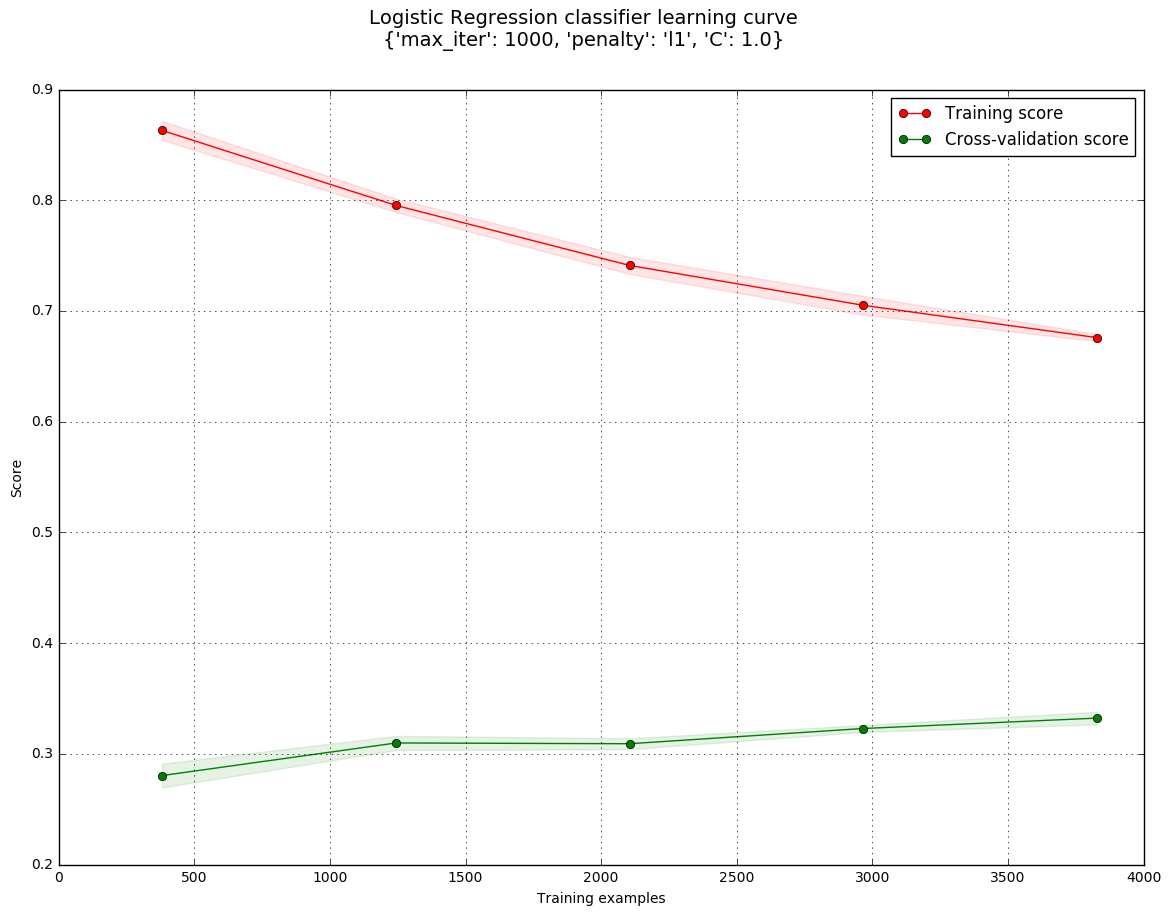

             precision    recall  f1-score   support

      Angry       0.23      0.18      0.20       187
    Disgust       0.00      0.00      0.00        18
       Fear       0.18      0.13      0.15       207
      Happy       0.40      0.58      0.47       350
        Sad       0.27      0.25      0.26       251
   Surprise       0.44      0.41      0.43       157
    Neutral       0.28      0.25      0.27       267

avg / total       0.30      0.32      0.30      1437



In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

from utils import plot_learning_curve
from emotions import load


X_chunk0, y_chunk0 = load(DATA_FOLDER, 'emotions', subset_index=0)
X_chunk1, y_chunk1 = load(DATA_FOLDER, 'emotions', subset_index=1)
X_more, y_more = np.r_[X_chunk0, X_chunk1], np.r_[y_chunk0, y_chunk1]

log.info('X shape = %s, y shape = %s', X_more.shape, y_more.shape)

X_more_train, X_more_test, y_more_train, y_more_test = train_test_split(
    MinMaxScaler().fit_transform(X_more), y_more, random_state=RANDOM_STATE, test_size=0.2)

best_logreg_params = {'C': 1.0, 'penalty': 'l1', 'max_iter': 1000}
best_model = LogisticRegression(random_state=RANDOM_STATE)
best_model.set_params(**best_logreg_params)
title = 'Logistic Regression classifier learning curve\n%s' % best_logreg_params
fig = plot_learning_curve(best_model, title, X_more_train, y_more_train)
display(fig)

best_model.fit(X_more_train, y_more_train)
y_preds = best_model.predict(X_more_test)
report = classification_report(y_more_test, y_preds, target_names=loader.VERBOSE_EMOTION)
print(report)

Data size increasing has some effect on estimator's accuracy, but not too big. Also note that as it was earlier mentioned, dataset is unbalanced and some facial emotions are underrepresented. For example, `Disgust` labels are much more rare then `Happy` or `Neutral`.

In [3]:
# Restore the whole dataset from chunks
import glob

n_total = len(list(glob.glob1(DATA_FOLDER, '*.npy'))) // 2
Xs, ys = zip(*[load(DATA_FOLDER, 'emotions', subset_index=i) for i in range(n_total)])             
X, y = np.r_[Xs], np.r_[ys]        
log.info('X shape = %s, y shape = %s', X.shape, y.shape)

[2017-01-11 04:32:33,574] notebook: X shape = (35887, 2304), y shape = (35887,)


In [4]:
# Apply logistic regression to this data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

from utils import Timer, save_model


X_train, X_test, y_train, y_test = train_test_split(
    MinMaxScaler().fit_transform(X), y, random_state=RANDOM_STATE, test_size=0.1)

full_model = LogisticRegression(C=1.0, penalty='l1', max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
log.info('Fitting model using full dataset..')
with Timer() as timer:
    full_model.fit(X_train, y_train)
save_model(full_model, DATA_FOLDER, 'logreg.model')
log.info("Time elapsed to fit model: %s", timer)

[2017-01-11 04:32:35,882] notebook: Fitting model using full dataset..
[2017-01-11 04:49:02,188] notebook: Time elapsed to fit model: 00:16:26


             precision    recall  f1-score   support

      Angry       0.27      0.17      0.21       475
    Disgust       0.40      0.08      0.13        51
       Fear       0.29      0.16      0.21       548
      Happy       0.43      0.66      0.52       894
        Sad       0.28      0.27      0.27       600
   Surprise       0.43      0.45      0.44       384
    Neutral       0.33      0.33      0.33       637

avg / total       0.35      0.36      0.34      3589



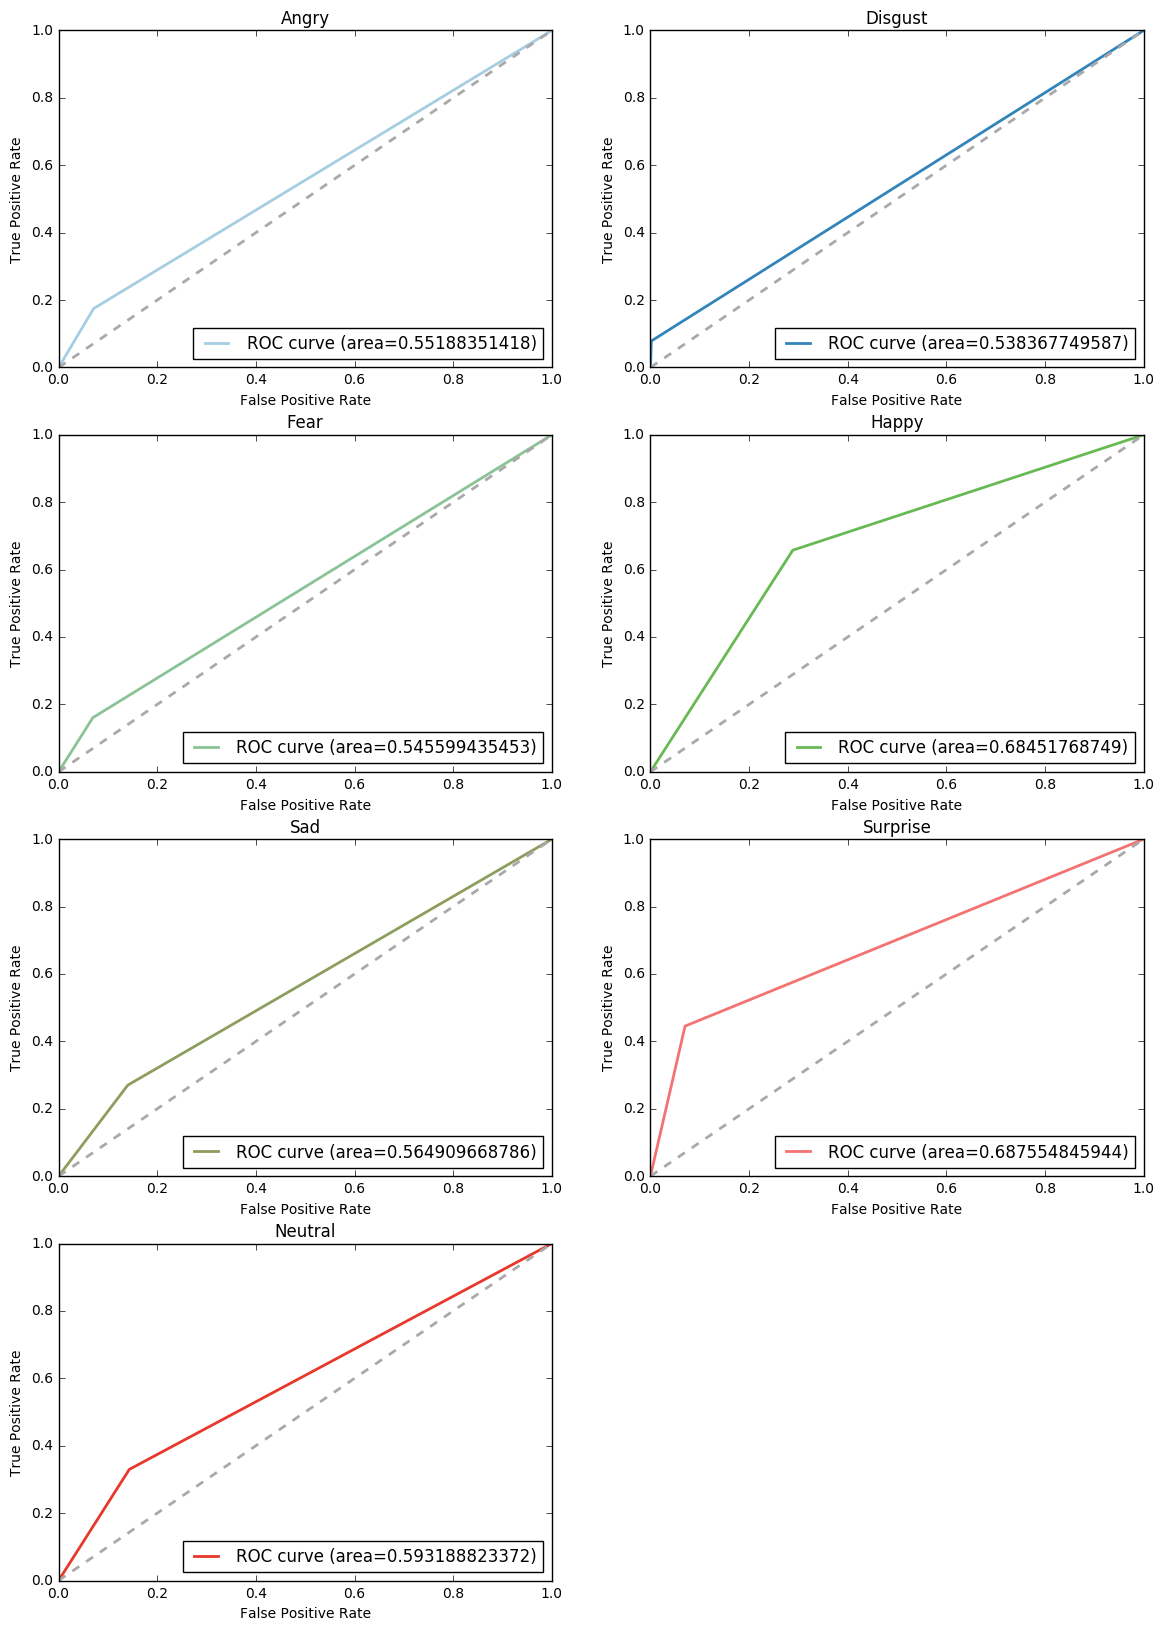

In [29]:
from itertools import chain

from sklearn.metrics import classification_report, roc_curve
from IPython.display import display
import matplotlib.pyplot as plt

from utils import load_model, plot_roc_curve
from emotions import FER2013Dataset


target_names = FER2013Dataset.VERBOSE_EMOTION
full_model = load_model(DATA_FOLDER, 'logreg.model')
y_preds = full_model.predict(X_test)
print(classification_report(y_test, y_preds, target_names=target_names))

colors = plt.get_cmap('Paired')
roc_curves, axes = plt.subplots(4, 2, figsize=(14, 20))
axes = list(chain(*axes))
for label, ax in zip(full_model.classes_, axes):    
    binary_test = [int(y == label) for y in y_test]
    binary_pred = [int(y == label) for y in y_preds]    
    plot_roc_curve(binary_test, binary_pred, color=colors(label * 20), ax=ax)
    ax.set_title(target_names[label])
axes[-1].remove()
    
display(roc_curves)

As it follows from the calculated metrics and ROC-curves, `LogisticRegression` classifier doesn't perform well on emotions dataset.

### Ensemble Models

The second baseline model is an ensemble classifier, or more precisely, `ExtraTreesClassifier`. One advantage of ensemble models is that these methods allows to combine together a bunch of _weak learners_ - predictors, which if applied standalone show low prediction accuracy, but when combined together and have enough data could show good results.

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from basedir import DATA_FOLDER
from emotions import load


param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [100, 500, 1000, 2000]
}

X, y = load(DATA_FOLDER, 'emotions', subset_index=0)
X_norm = MinMaxScaler().fit_transform(X)

log.info('X shape: %s, y shape: %s', X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, random_state=RANDOM_STATE, test_size=0.1)
model = ExtraTreesClassifier(random_state=RANDOM_STATE)

log.info("Selected baseline model: %s", str(model.__class__.__name__))
grid_search = GridSearchCV(estimator=model, cv=5, param_grid=param_grid, n_jobs=-1, verbose=1)
_ = grid_search.fit(X_train, y_train.ravel())

In [40]:
best_model = grid_search.best_estimator_
best_model_params = grid_search.best_params_
logreg_cv_results = grid_search.cv_results_
param_cols = [c for c in logreg_cv_results.keys() if c.startswith('param_')]

columns_of_interest = [
    'mean_fit_time', 
    'mean_train_score', 'std_train_score',
    'mean_test_score', 'std_test_score']
columns_of_interest.extend(param_cols)

df_cv_results = pd.DataFrame(logreg_cv_results)[columns_of_interest]
display(df_cv_results)
log.debug("Best parameters: %s", best_model_params)

,mean_fit_time,mean_train_score,std_train_score,mean_test_score,std_test_score,param_max_features,param_criterion,param_n_estimators
0,4.178936,0.998994,0.000395,0.348391,0.011824,sqrt,gini,100
1,21.391440,0.998994,0.000395,0.359530,0.009084,sqrt,gini,500
2,41.041685,0.998994,0.000395,0.360149,0.005618,sqrt,gini,1000
3,83.845105,0.998994,0.000395,0.359220,0.004357,sqrt,gini,2000
4,1.658591,0.998994,0.000395,0.331374,0.007275,log2,gini,100
5,7.835880,0.998994,0.000395,0.336634,0.007902,log2,gini,500
6,15.780764,0.998994,0.000395,0.339418,0.009580,log2,gini,1000
7,31.782852,0.998994,0.000395,0.339418,0.010488,log2,gini,2000
8,5.584948,0.998994,0.000395,0.341584,0.006537,sqrt,entropy,100
9,28.445830,0.998994,0.000395,0.341584,0.008848,sqrt,entropy,500


[2017-01-11 06:07:06,630] notebook: Best parameters: {'n_estimators': 1000, 'criterion': 'gini', 'max_features': 'sqrt'}


Again, as it was performed for logistic model, let's plot training curve to see if amount of data affects model's performance.

[2017-01-15 07:23:57,942] notebook: X shape = (7183, 2304), y shape = (7183,)


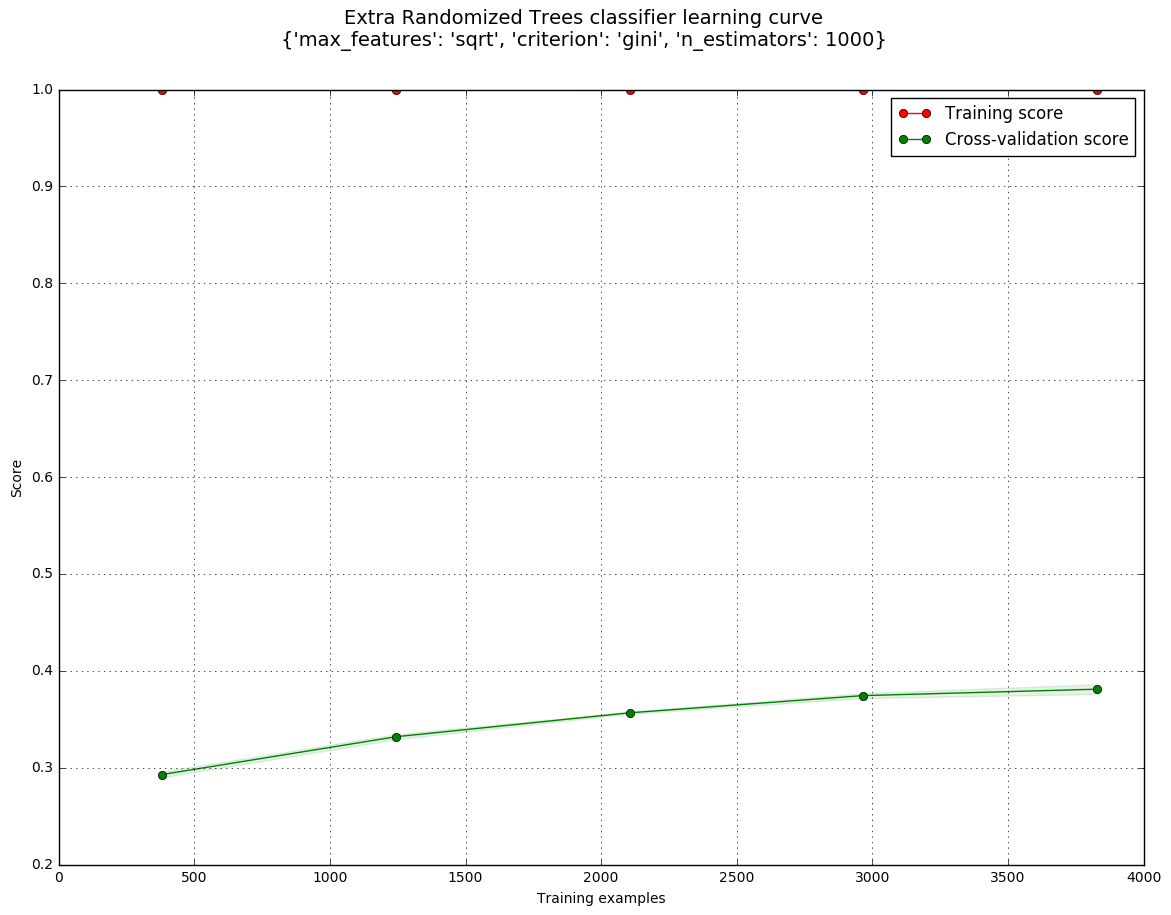

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler

from basedir import DATA_FOLDER
from emotions import load


X_chunk0, y_chunk0 = load(DATA_FOLDER, 'emotions', subset_index=0)
X_chunk1, y_chunk1 = load(DATA_FOLDER, 'emotions', subset_index=1)
X_more, y_more = np.r_[X_chunk0, X_chunk1], np.r_[y_chunk0, y_chunk1]

log.info('X shape = %s, y shape = %s', X_more.shape, y_more.shape)

X_more_train, X_more_test, y_more_train, y_more_test = train_test_split(
    MinMaxScaler().fit_transform(X_more), y_more, random_state=RANDOM_STATE, test_size=0.2)


best_model_params = {'n_estimators': 1000, 'criterion': 'gini', 'max_features': 'sqrt'}
best_model = ExtraTreesClassifier(random_state=RANDOM_STATE)
best_model.set_params(**best_model_params)
title = 'Extra Randomized Trees classifier learning curve\n%s' % best_model_params
fig = plot_learning_curve(best_model, title, X_more_train, y_more_train)
display(fig)

In [12]:
from sklearn.metrics import classification_report

from emotions import FER2013Dataset

best_model.fit(X_more_train, y_more_train)
y_preds = best_model.predict(X_more_test)
print(classification_report(y_more_test, y_preds, target_names=FER2013Dataset.VERBOSE_EMOTION))

             precision    recall  f1-score   support

      Angry       0.46      0.09      0.15       187
    Disgust       1.00      0.11      0.20        18
       Fear       0.40      0.15      0.22       207
      Happy       0.37      0.81      0.51       350
        Sad       0.37      0.35      0.36       251
   Surprise       0.62      0.48      0.54       157
    Neutral       0.36      0.27      0.31       267

avg / total       0.42      0.39      0.36      1437



The last step is to train the second baseline model on the whole amount of data to make it comparable with other developed estimators.

In [3]:
# Restore the whole dataset from chunks
import glob

n_total = len(list(glob.glob1(DATA_FOLDER, '*.npy'))) // 2
Xs, ys = zip(*[load(DATA_FOLDER, 'emotions', subset_index=i) for i in range(n_total)])             
X, y = np.r_[Xs], np.r_[ys]        
log.info('X shape = %s, y shape = %s', X.shape, y.shape)

[2017-01-15 08:35:15,317] notebook: X shape = (35887, 2304), y shape = (35887,)


> **Note**: It wasn't possible to pickle the trained tree model to the storage because of it's huge volume (>= 2 GB) and `joblib.dump` raised an `Out of memory` exception. Therefore, as soon as model is trained, it is used to make predictions on the whole dataset.

[2017-01-15 08:51:40,709] notebook: Fitting model using full dataset..
[2017-01-15 08:58:02,411] notebook: Time elapsed to fit model: 00:06:21


             precision    recall  f1-score   support

      Angry       0.73      0.20      0.31       475
    Disgust       1.00      0.35      0.52        51
       Fear       0.64      0.32      0.42       548
      Happy       0.44      0.85      0.58       894
        Sad       0.40      0.41      0.41       600
   Surprise       0.71      0.61      0.66       384
    Neutral       0.51      0.40      0.45       637

avg / total       0.55      0.50      0.48      3589



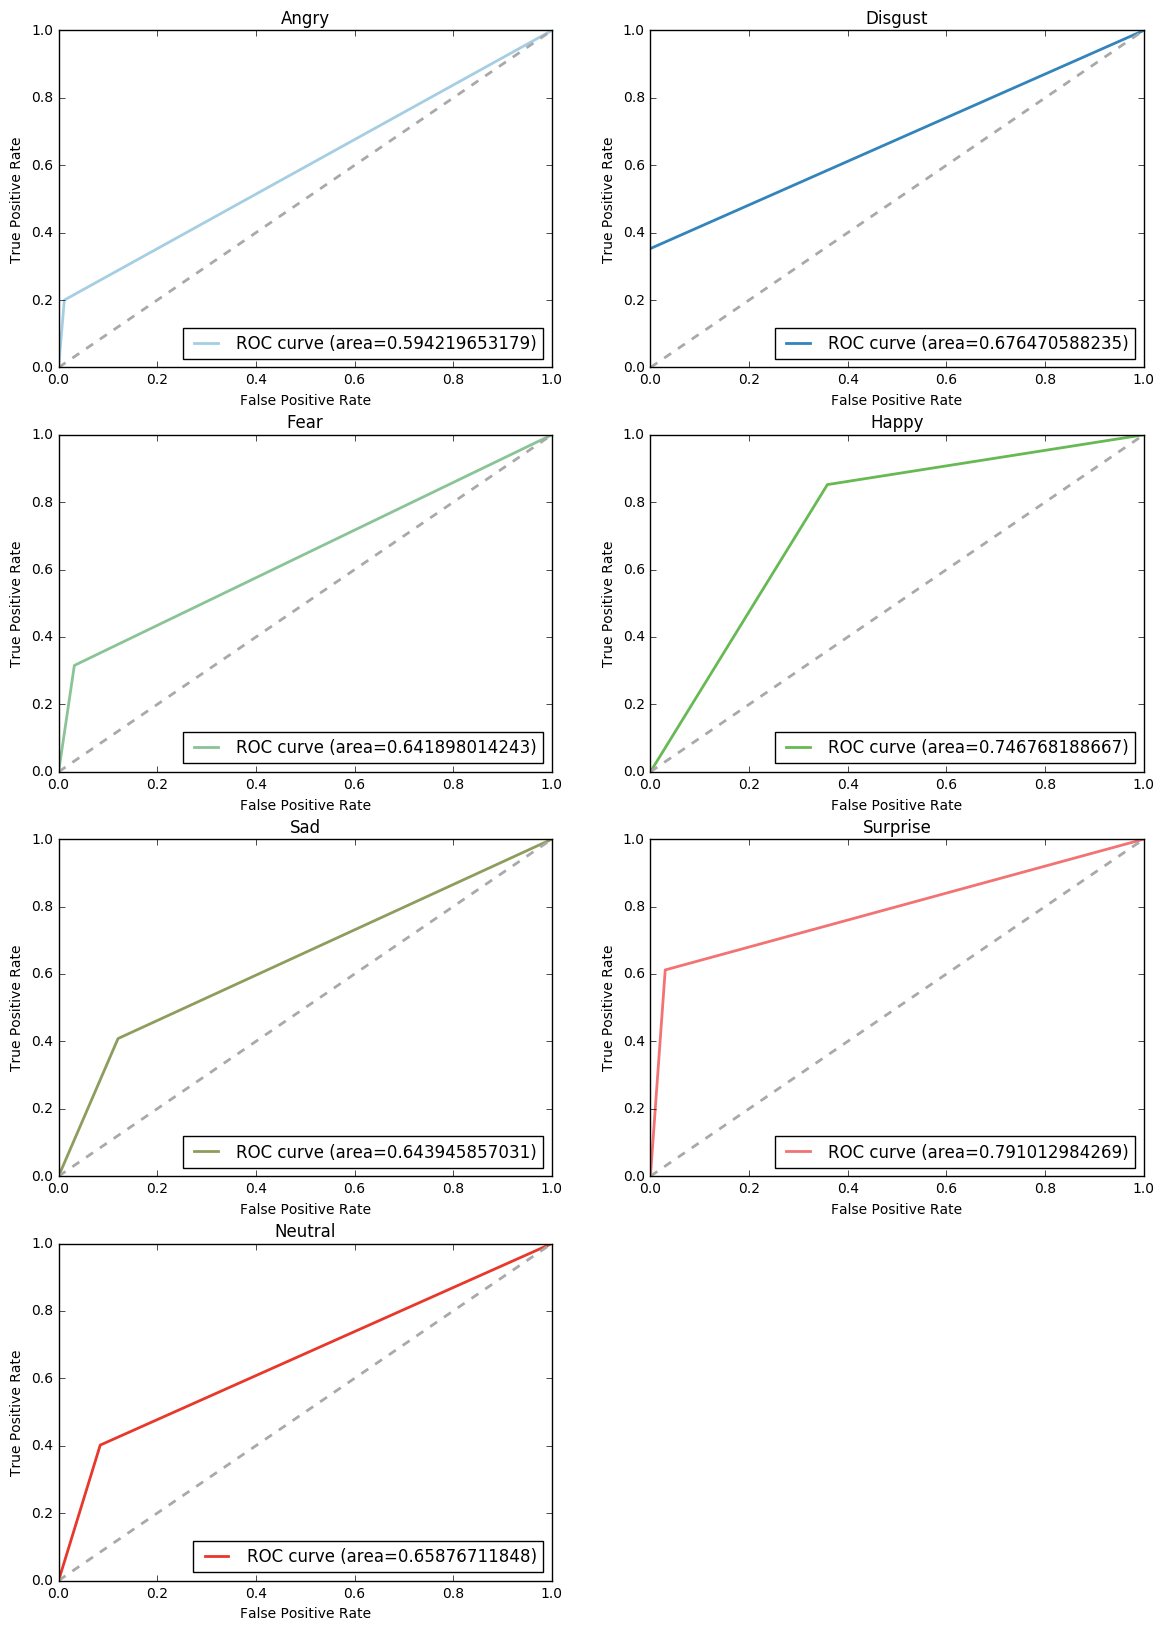

In [8]:
# Apply ensemble model (extra trees) to the whole dataset
from itertools import chain

from sklearn.metrics import classification_report, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt

from utils import Timer, save_model, plot_roc_curve
from emotions import FER2013Dataset


X_train, X_test, y_train, y_test = train_test_split(
    MinMaxScaler().fit_transform(X), y, random_state=RANDOM_STATE, test_size=0.1)

full_model = ExtraTreesClassifier(n_estimators=1000, criterion='gini', max_features='sqrt')
log.info('Fitting model using full dataset..')
with Timer() as timer:
    full_model.fit(X_train, y_train)
log.info("Time elapsed to fit model: %s", timer)

target_names = FER2013Dataset.VERBOSE_EMOTION
y_preds = full_model.predict(X_test)
print(classification_report(y_test, y_preds, target_names=target_names))

colors = plt.get_cmap('Paired')
roc_curves, axes = plt.subplots(4, 2, figsize=(14, 20))
axes = list(chain(*axes))
for label, ax in zip(full_model.classes_, axes):    
    binary_test = [int(y == label) for y in y_test]
    binary_pred = [int(y == label) for y in y_preds]    
    plot_roc_curve(binary_test, binary_pred, color=colors(label * 20), ax=ax)
    ax.set_title(target_names[label])
axes[-1].remove()
    
display(roc_curves)

Also it could be noted that `Happy` and `Surprise` emotions are again identified much better then `Angry` and `Disgust`.

## Deep Learning Approach

In this section more sophisticated models will be applied to emotions dataset to achieve higher levels of accuracy. Deep learning networks perform quite well on doing a variety of "human tasks" like image and voice recognition, text and audio generation, etc. Therefore, it is supposed that neural networks will handle emotions recognition problem better then baseline models, presented before.


In [1]:
from itertools import chain
import logging.config
import os
import io

from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.utils.visualize_util import plot as plot_keras_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from emotions import FER2013Dataset, load_all
from settings import LOGGING_CONFIG
from basedir import DATA_FOLDER
from utils import sample_images, Timer
from networks import init_model


RANDOM_STATE = 1


logging.config.dictConfig(LOGGING_CONFIG)
log = logging.getLogger('notebook')

Using TensorFlow backend.


In [2]:
# All available data
X, y = load_all(DATA_FOLDER, 'emotions')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)
log.info('All available data stas')
log.info('[Full] X shape:       %s | y shape:       %s', X.shape, y.shape)
log.info('[Full] X train shape: %s | y train shape: %s', X_train.shape, y_train.shape)
log.info('-' * 80)

X_train /= 255.0
X_test /= 255.0

# Only 3/10 of all available data
X_small, y_small = load_all(DATA_FOLDER, 'emotions', head=3)
X_train_small, X_test_small, y_train_small, y_test_small = \
    train_test_split(X_small, y_small, test_size=0.2, random_state=RANDOM_STATE)
log.info('Small subset of data stats')
log.info('[Small] X shape:       %s | y shape:       %s', X_small.shape, y_small.shape)
log.info('[Small] X train shape: %s | y train shape: %s', X_train_small.shape, y_train_small.shape)   

X_train_small /= 255.0
X_test_small /= 255.0

[2017-01-23 09:10:36,956] notebook: All available data stas
[2017-01-23 09:10:36,958] notebook: [Full] X shape:       (35887, 2304) | y shape:       (35887,)
[2017-01-23 09:10:36,960] notebook: [Full] X train shape: (32298, 2304) | y train shape: (32298,)
[2017-01-23 09:10:36,961] notebook: --------------------------------------------------------------------------------
[2017-01-23 09:10:37,507] notebook: Small subset of data stats
[2017-01-23 09:10:37,508] notebook: [Small] X shape:       (10773, 2304) | y shape:       (10773,)
[2017-01-23 09:10:37,509] notebook: [Small] X train shape: (8618, 2304) | y train shape: (8618,)


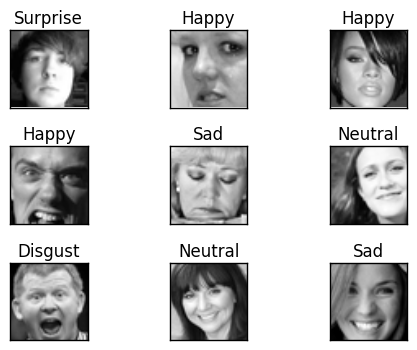

In [9]:
fig, _ = sample_images(X_train_small, y_small)
fig

---

### Basic Model

To begin with deep learning approach, the most simple models were used at first. Each model represeted in this section is a **feedforward** network with several hidden layers. Each model is supported with graphical layers graph and schematical description.

In [4]:
import imp
import networks
imp.reload(networks)

<module 'networks' from '/Users/ck/Code/Nanodegrees/ML/capstone/networks.py'>

In [5]:
def show_model_graph(wrapper):
    """Utility function to show model graph image in notebook."""
    filename = os.path.join(DATA_FOLDER, wrapper.name + '.png')
    plot_keras_model(wrapper.model, to_file=filename)
    return Image(filename=filename) 


def create_network(name, verbose=0, model_params=None, **compile_params):
    wrapper = init_model(name)
    model = wrapper.build(**(model_params or {}))
    if verbose >= 1:
        log.info("Model '%s' architecture:", name)
        display(show_model_graph(wrapper))
    if compile_params:
        model.compile(**compile_params)
    return model


def score_network(X, y, name, n_splits=3, nb_epoch=10, batch_size=150, verbose=2, 
                  model_params=None, callbacks=None, **compile_params):
    """Scores a specific model using stratified K-fold approach."""
    
    _ = create_network(name, model_params=model_params, verbose=1)        
    k_fold = StratifiedKFold(n_splits=n_splits, random_state=RANDOM_STATE)
    y_hot = np_utils.to_categorical(y)
        
    cv_scores = []
    log.info("Dataset to train model: X.shape = %s, y.shape = %s", X.shape, y.shape)
        
    if callbacks is None:
        callbacks = [EarlyStopping(min_delta=0.001)]
        
    with Timer() as timer:
        for i, (train, val) in enumerate(k_fold.split(X, y), 1):
            log.info('Split #%d', i)
            model = create_network(name, **compile_params)
            h = model.fit(
                X[train], y_hot[train],
                nb_epoch=nb_epoch,
                batch_size=batch_size,
                validation_data=(X_train_small[val], y_hot[val]), 
                verbose=verbose, 
                callbacks=callbacks).history
            cv_scores.append(h)
    log.info("Total scoring time (%d folds): %s", n_splits, str(timer))
        
    df_cv_scores = list(map(pd.DataFrame, cv_scores))
    names = model.metrics_names + ['val_%s' % name for name in model.metrics_names]
    scoring = pd.DataFrame()
    for name in names:
        all_runs = pd.concat([df[name] for df in df_cv_scores], axis=1)
        avg_for_epoch = all_runs.mean(axis=1)
        scoring[name] = avg_for_epoch

    log.info("Average scores per epoch:")
    display(scoring)
    return model, scoring

In [28]:
def plot_metrics(test_metric_names, scoring, model_name, ax_height=8, ax_width=8):
    """Plots average metrics for gathered during model training."""
    from itertools import chain
    import math
    
    n_metrics = len(test_metric_names)    
    n_axes = n_metrics * 2
    hide_last_axis = n_metrics % 2 != 0
    figsize = (ax_width * 2, ax_height * (n_metrics // 2))
    
    fig, axes = plt.subplots(math.ceil(n_metrics / 2), 2, figsize=figsize)    
    fig.suptitle("Model '%s' scoring metrics" % model_name, fontsize=14)
    
    try:
        axes = list(chain(*axes))
    except TypeError:
        pass  # already has correct shape    
    
    epoches = [x + 1 for x in scoring.index.tolist()]
    for name, ax in zip(test_metric_names, axes):
        ax.plot(epoches, scoring[name], 'r-', label=name)
        ax.plot(epoches, scoring['val_' + name], 'b-', label='%s (validation)' % name)
        ax.set_xlabel('# of epoch', fontsize=14)
        ax.legend(loc='best')
        ax.grid()
        
    if hide_last_axis:
        axes[-1].axis('off')        
        
    return fig

The first `trivial` model  is a simple **feedforward** network represented on the graph below. It has the following structure:
```
[Input: 2304 (48x48)] -> [Dense: 2304, ReLU] -> [Output: 7, softmax]
```

In [7]:
compile_params = dict(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['categorical_accuracy'])    

[2017-01-23 09:11:12,190] notebook: Model 'trivial' architecture:


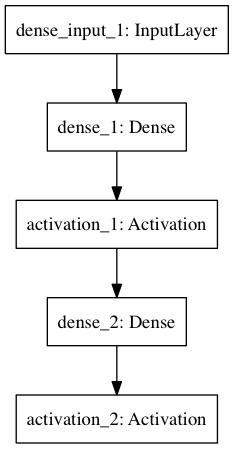

[2017-01-23 09:11:12,262] notebook: Dataset to train model: X.shape = (8618, 2304), y.shape = (8618,)
[2017-01-23 09:11:12,266] notebook: Split #1
[2017-01-23 09:11:59,336] notebook: Split #2
[2017-01-23 09:12:47,741] notebook: Split #3
[2017-01-23 09:13:38,753] notebook: Total scoring time (3 folds): 00:02:26
[2017-01-23 09:13:38,771] notebook: Average scores per epoch:


,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,11.375167,0.157752,11.560780,0.168368
1,11.607294,0.163553,11.476894,0.167552
2,11.058452,0.172081,10.871499,0.167771
3,10.760624,0.183395,10.813375,0.177298
4,10.884848,0.181769,11.102864,0.169180
5,10.866381,0.184157,10.875807,0.183445
6,10.740646,0.186645,10.791250,0.168604
7,10.680228,0.195408,10.818347,0.178574
8,10.685445,0.195758,10.798272,0.167216
9,10.659753,0.202949,10.719247,0.173345


In [8]:
model, scoring = score_network(
    X_train_small, y_train_small, 'trivial',
    callbacks=[], verbose=0, nb_epoch=10, **compile_params)

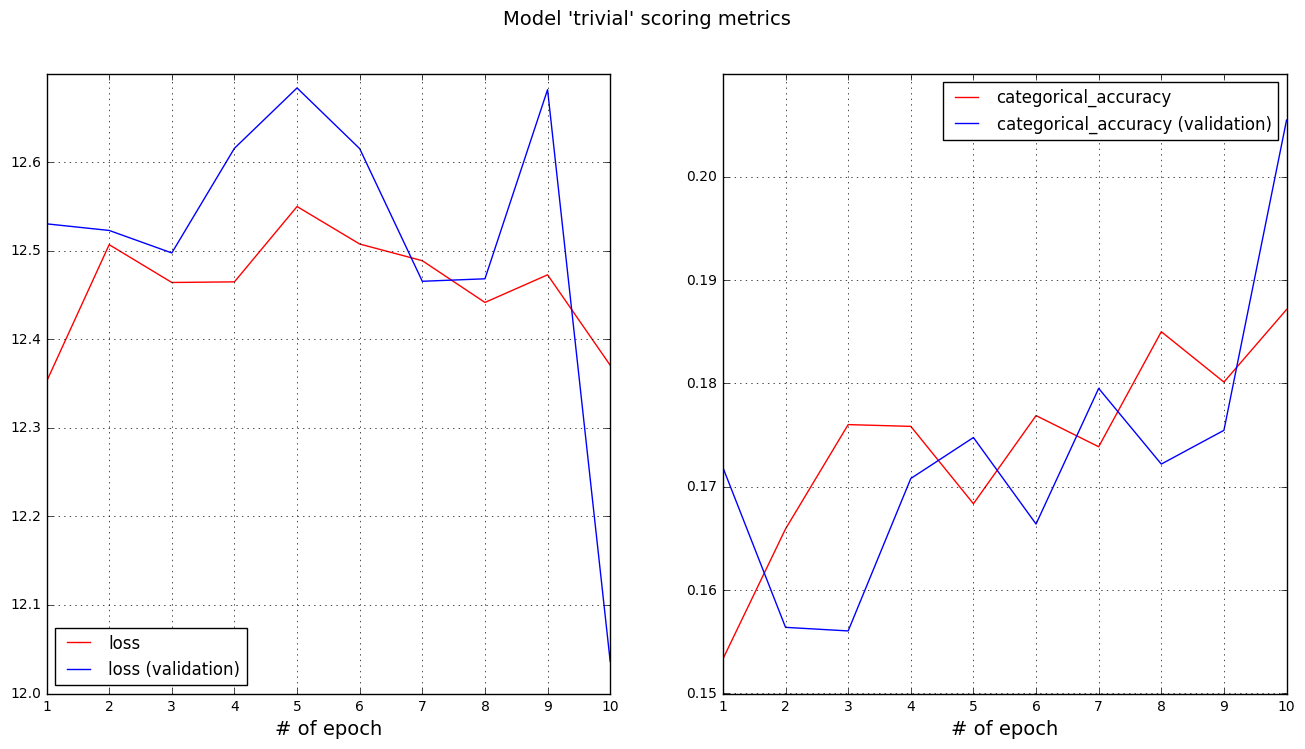

In [98]:
plot_metrics(model.metrics_names, scoring, 'trivial')

[2017-01-23 09:15:14,921] notebook: Model 'simple' architecture:


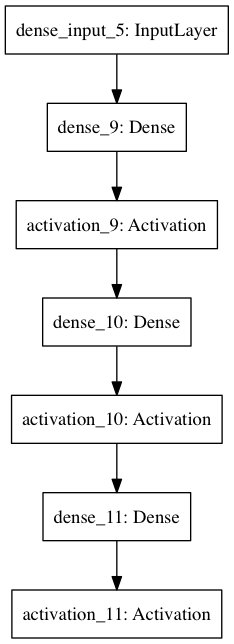

[2017-01-23 09:15:14,978] notebook: Dataset to train model: X.shape = (8618, 2304), y.shape = (8618,)
[2017-01-23 09:15:14,983] notebook: Split #1
[2017-01-23 09:16:58,408] notebook: Split #2
[2017-01-23 09:18:39,190] notebook: Split #3
[2017-01-23 09:20:25,627] notebook: Total scoring time (3 folds): 00:05:10
[2017-01-23 09:20:25,636] notebook: Average scores per epoch:


,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,2.136230,0.142667,2.019511,0.139011
1,2.019548,0.139011,2.019505,0.139011
2,2.019536,0.139011,2.019504,0.139011
3,2.019530,0.139011,2.019504,0.139011
4,2.019524,0.139011,2.019505,0.139011
5,2.019513,0.139011,2.019505,0.139011
6,2.019503,0.139011,2.019506,0.139011
7,2.019492,0.139011,2.019507,0.139011
8,2.019478,0.139127,2.019508,0.139011
9,2.019462,0.139185,2.019510,0.139011


In [10]:
model, scoring = score_network(
    X_train_small, y_train_small, 'simple',
    nb_epoch=10, batch_size=500,
    callbacks=[], verbose=0, **compile_params)

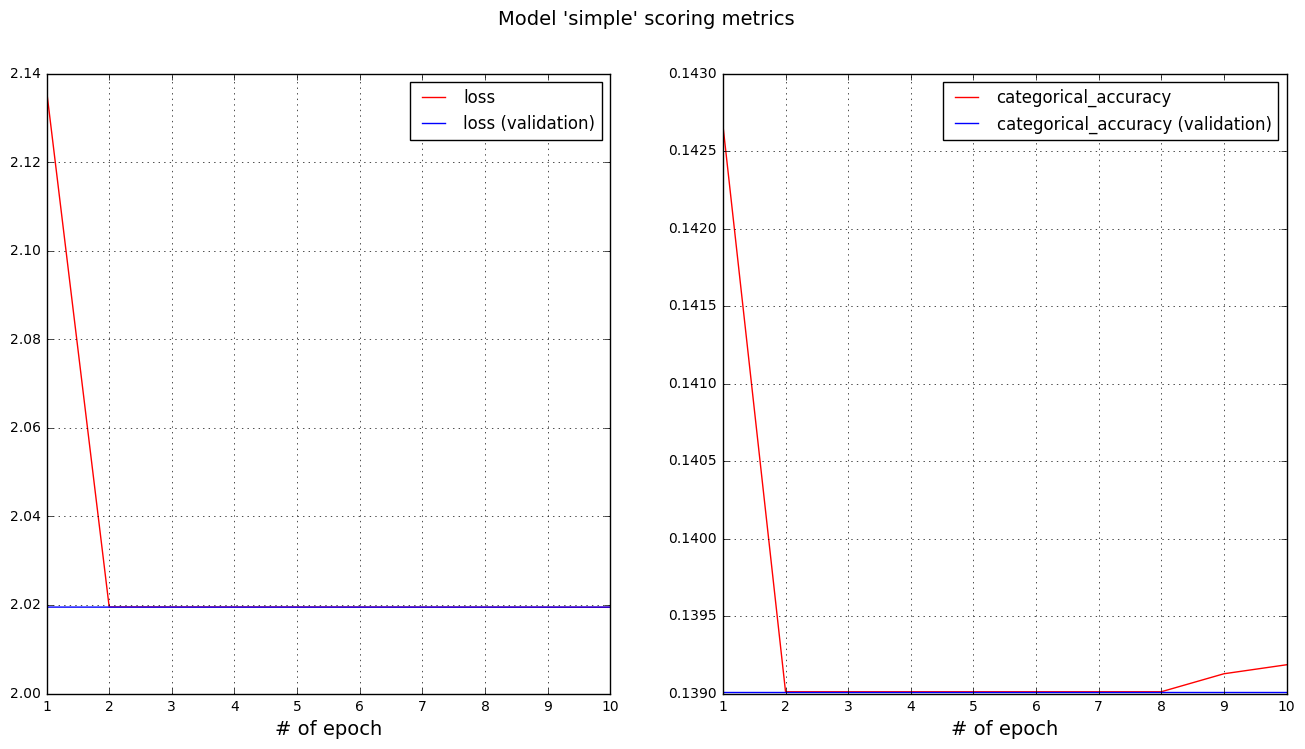

In [11]:
plot_metrics(model.metrics_names, scoring, 'simple')

As could be noted, simple schemes doesn't give good results. Actually, they perform quite bad. Especially notable the second one. It seems that selected architecture, depth, or types of activation functions are not fit for the problem. There is no any improvement during validation and this model performs even worse then the trivial one.

[2017-01-23 09:24:29,695] notebook: Model 'dropout_const' architecture:


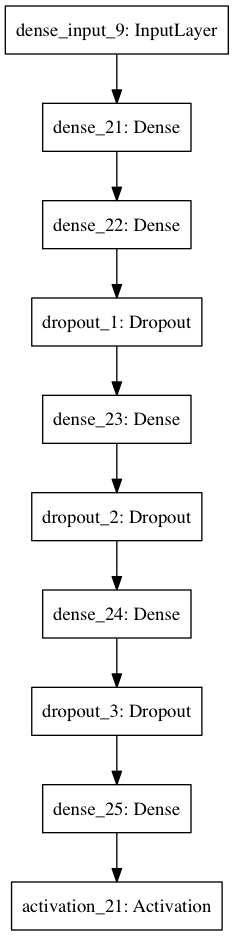

[2017-01-23 09:24:29,754] notebook: Dataset to train model: X.shape = (8618, 2304), y.shape = (8618,)
[2017-01-23 09:24:29,760] notebook: Split #1


Train on 6892 samples, validate on 1726 samples
Epoch 1/10
6892/6892 [==============================] - 21s - loss: 2.4439 - categorical_accuracy: 0.1394 - fmeasure: 0.2766 - val_loss: 2.0242 - val_categorical_accuracy: 0.1390 - val_fmeasure: 0.2811

[2017-01-23 09:25:16,028] notebook: Split #2



Train on 6893 samples, validate on 1725 samples
Epoch 1/10
6893/6893 [==============================] - 22s - loss: 2.3599 - categorical_accuracy: 0.1388 - fmeasure: 0.2772 - val_loss: 2.0243 - val_categorical_accuracy: 0.1391 - val_fmeasure: 0.2811

[2017-01-23 09:26:01,377] notebook: Split #3



Train on 6894 samples, validate on 1724 samples
Epoch 1/10
6894/6894 [==============================] - 21s - loss: 2.2292 - categorical_accuracy: 0.1358 - fmeasure: 0.2779 - val_loss: 2.0161 - val_categorical_accuracy: 0.1392 - val_fmeasure: 0.2812

[2017-01-23 09:26:44,641] notebook: Split #4



Train on 6895 samples, validate on 1723 samples
Epoch 1/10
6895/6895 [==============================] - 21s - loss: 2.3236 - categorical_accuracy: 0.1363 - fmeasure: 0.2471 - val_loss: 1.9459 - val_categorical_accuracy: 0.1393 - val_fmeasure: 0.2500

[2017-01-23 09:27:28,480] notebook: Split #5



Train on 6898 samples, validate on 1720 samples
Epoch 1/10
6898/6898 [==============================] - 23s - loss: 2.4440 - categorical_accuracy: 0.1413 - fmeasure: 0.2505 - val_loss: 1.9459 - val_categorical_accuracy: 0.1384 - val_fmeasure: 0.2500

[2017-01-23 09:28:14,868] notebook: Total scoring time (5 folds): 00:03:45
[2017-01-23 09:28:14,883] notebook: Average scores per epoch:


,loss,categorical_accuracy,fmeasure,val_loss,val_categorical_accuracy,val_fmeasure
0,2.360134,0.138344,0.265873,1.991274,0.139011,0.268679
1,1.992298,0.139011,0.269411,1.991277,0.139011,0.268679


(<keras.models.Sequential at 0x12ded6438>,
        loss  categorical_accuracy  fmeasure  val_loss  \
 0  2.360134              0.138344  0.265873  1.991274   
 1  1.992298              0.139011  0.269411  1.991277   
 
    val_categorical_accuracy  val_fmeasure  
 0                  0.139011      0.268679  
 1                  0.139011      0.268679  )

In [13]:
nb_epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / nb_epochs

optimizer = SGD(lr=learning_rate, decay=decay_rate)
model = score_network(
    X_train_small, y_train_small, 'dropout_const', 
    n_splits=5, nb_epoch=nb_epochs, 
    batch_size=500, 
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy', 'f1score'],              
    callbacks=[EarlyStopping()],
    model_params={'output_activation': 'softmax', 'dropout': 0.3},
    optimizer=optimizer,
    verbose=1)

---
### Convolutional Architecture

As it could be seen from previous attempts, simple feedforward architectures probably too "shallow" to extract prominent features from emotions dataset.

Convolutional models requires a specific structure of training data. In previous sections, images were ***flatten*** into 1D-arrays. So basically, we had vectors $48 \times 48 = 2304$ of features:

$$
\vec{v} = (v_1, v_2, ..., v_{2304})
$$

But now spacial information will be preserved. Therefore, the network will accept as inputs 2D arrays representing face images:

$$
M = 
\begin{bmatrix}
    m_{1,1}  & m_{1,2}  & \dots  & m_{1,48} \\
    m_{2,1}  & m_{2,2}  & \dots  & m_{2,48} \\
    \vdots   & \vdots   & \ddots & \vdots   \\
    m_{48,1} & m_{48,2} & \dots  & m_{48,48}
\end{bmatrix}
$$

Note that emotions dataset contains only grayscale images so arrays are 2-dimentional since there is only one color channel. Otherwise, we would have had $48 \times 48 \times 3$ shape.

Baseline convolutional model has the following architecture:

![img](docs/conv_simple.png)

The <font color='royalblue'><strong><em>first</em></strong></font> and the <font color='royalblue'><strong><em>last</em></strong></font> blocks represent input and output layers and will not be changed in next models (except maybe activation function of the output layer)

In [68]:
# All imports required for next steps
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.layers import Convolution2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.utils import np_utils
from keras import backend as K 
K.set_image_dim_ordering('th')

from emotions import FER2013Dataset, load, load_all
from settings import DATA_FOLDER
from utils import Timer

In [19]:
N_CLASSES = len(FER2013Dataset.VERBOSE_EMOTION)

def baseline_cnn_model():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, input_shape=(1, SIZE, SIZE), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))
    return model

In [60]:
size = FER2013Dataset.IMAGE_SIDE
X, y = load(DATA_FOLDER, 'emotions', subset_index=0)
X = X.reshape(X.shape[0], 1, size, size).astype('float32') / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

y_train_hot = np_utils.to_categorical(y_train)
model = baseline_cnn_model()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy', 'f1score'])
h = model.fit(X_train, y_train_hot,
              nb_epoch=10,
              batch_size=200,
              validation_split=0.2)
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred, target_names=FER2013Dataset.VERBOSE_EMOTION))

Train on 2585 samples, validate on 647 samples
Epoch 1/10
2585/2585 [==============================] - 13s - loss: 1.9387 - categorical_accuracy: 0.2271 - fmeasure: 0.0214 - val_loss: 1.8194 - val_categorical_accuracy: 0.2473 - val_fmeasure: 0.0000e+00

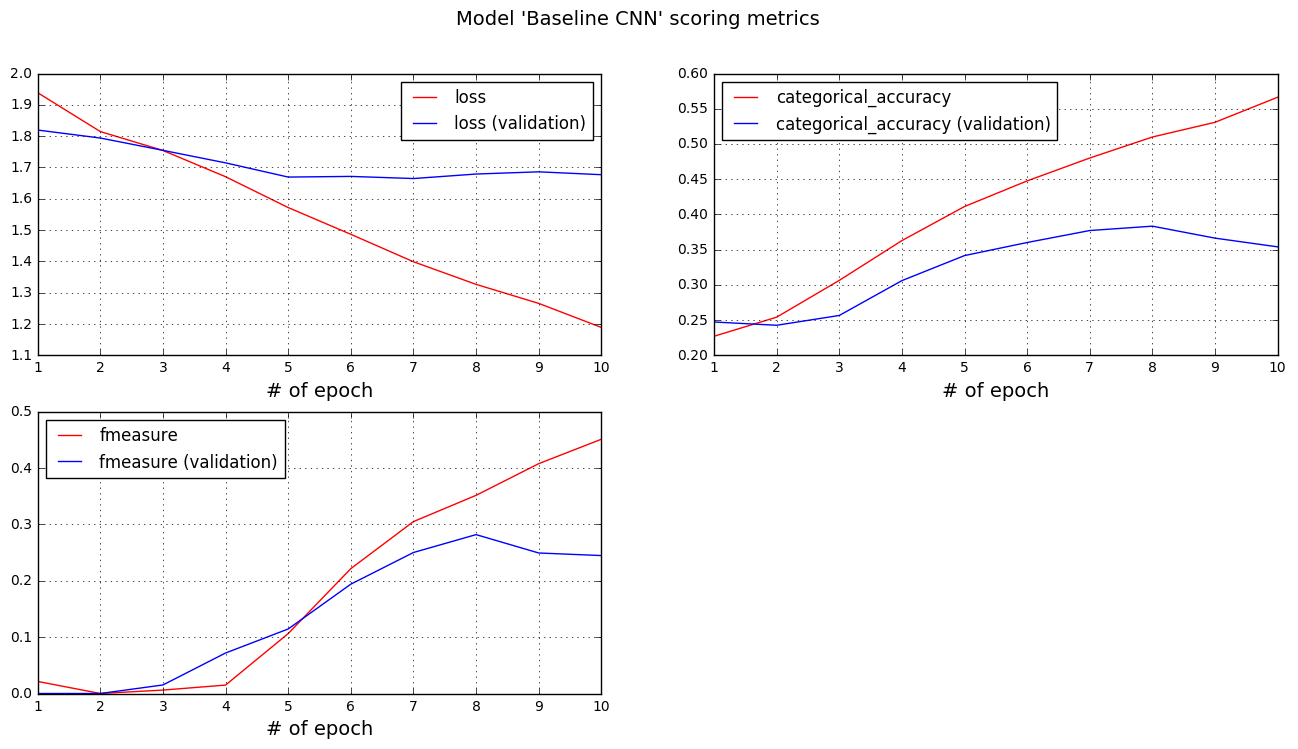

In [78]:
scoring = pd.DataFrame(h.history)
plot_metrics(model.metrics_names, scoring, 'Baseline CNN')

As it could be seen from generated reports and plots, there is an obvious progress during traning - each epoch increases traning accuracy and decreases loss. Therefore, this basic model could be used as a starting point for next improvements.

### Data Augmentation and Additional Preprocessing Steps

In case of deep learning models, some extra steps are advisable to be applied before model training and validation. More precisely, DL models could be especially sensitive to noise in data, affine transformations (shift, rotation) and adversarial exapmles [1]. To handle this problem it is usually recommend to extend the original dataset with additional records that will represent slightly and randomly modified original examples. This modified dataset is called **_augmented dataset_** and could improve network performance.

The augmented dataset could be generated in advance, or it could be generated "on the fly", i.e. during model's training. In this project, the later apporach was selected because `Keras` framework provides a quite suitable data augmentation generator which provides several augmentation techniques and yields images using asynchronous approach.

Therefore, next models will be trained using the augmented dataset.

In [55]:
TARGET_NAMES = FER2013Dataset.VERBOSE_EMOTION
N_CLASSES = len(TARGET_NAMES)
SIZE = FER2013Dataset.IMAGE_SIDE
N_PIXELS = FER2013Dataset.IMAGE_SIZE
RANDOM_STATE = 1

X, y = load_all(DATA_FOLDER, 'emotions')
X = X.reshape(X.shape[0], 1, SIZE, SIZE).astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)


def data_augmentation():
    return ImageDataGenerator(
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        featurewise_center=True,
        featurewise_std_normalization=True,
        zca_whitening=True)

Let's verify that augmentation process hasn't damaged dataset and augmented records still represent humans' faces

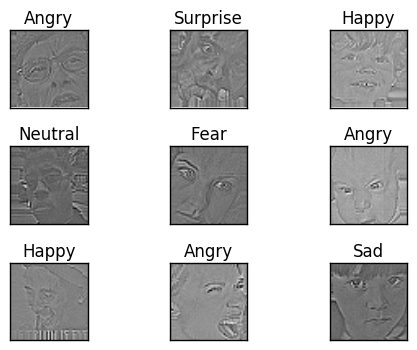

In [46]:
from utils import sample_images

datagen = data_augmentation()
datagen.fit(X)
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=100):
    X_flat = np.array([X_batch[i].reshape(48 ** 2) for i in range(100)])
    fig, _ = sample_images(X_flat, y_batch)
    display(fig)
    break

As it could be see from the sample above, augmented dataset still represents humans's faces.

In [62]:
y_hot_train = np_utils.to_categorical(y_train)

n_splits=10
kfold = StratifiedKFold(n_splits=n_splits, random_state=RANDOM_STATE)
train, val = next(kfold.split(X_train, y_train))
train_gen, val_gen = data_augmentation(), data_augmentation()
train_gen.fit(X_train[train])
val_gen.fit(X_train[val])

compile_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': 'adam',
    'metrics': ['categorical_accuracy', 'f1score']
}
model = baseline_cnn_model()
model.compile(**compile_params)
h = model.fit_generator(
    train_gen.flow(X_train[train], y_hot_train[train], batch_size=200),
    validation_data=val_gen.flow(X_train[val], y_hot_train[val]),
    samples_per_epoch=3000,
    nb_val_samples=200,
    nb_epoch=10, verbose=1)

Epoch 1/10
3000/3000 [==============================] - 16s - loss: 2.5620 - categorical_accuracy: 0.1793 - fmeasure: 0.0486 - val_loss: 2.6141 - val_categorical_accuracy: 0.1964 - val_fmeasure: 0.0079

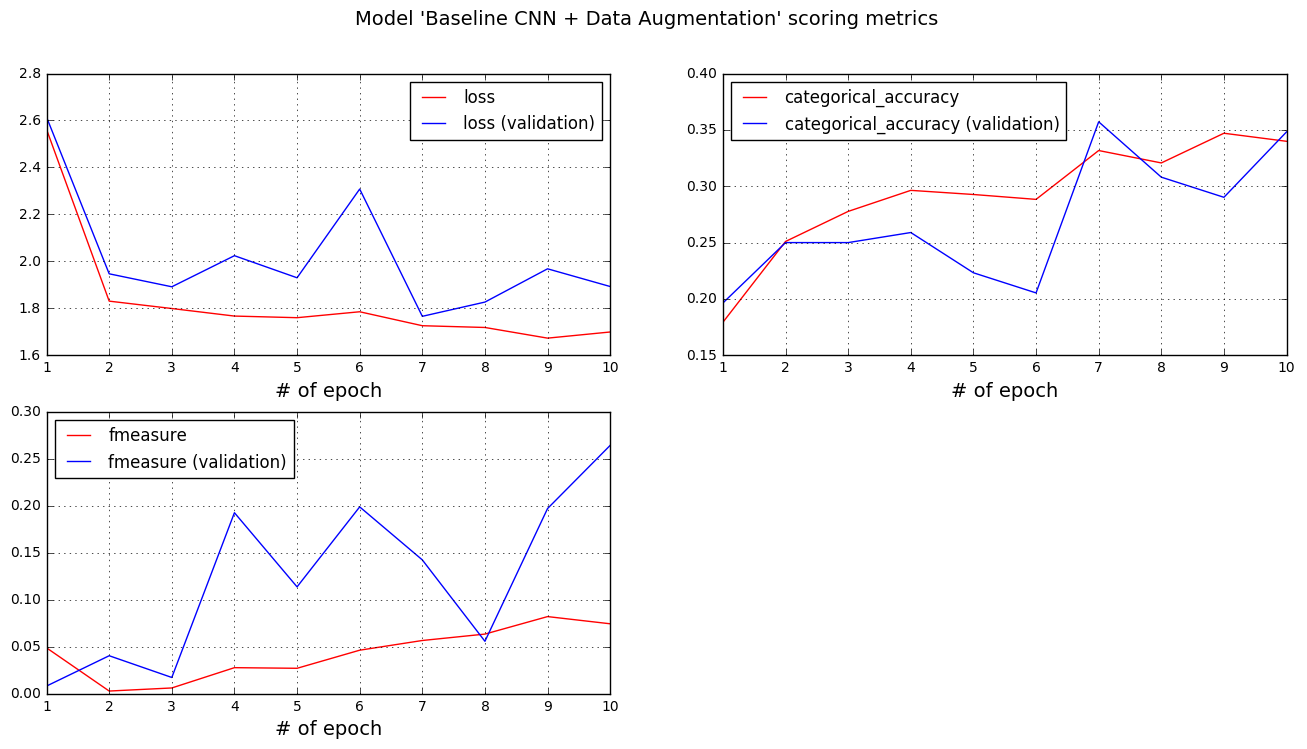

In [63]:
plot_metrics(model.metrics_names, pd.DataFrame(h.history), 'Baseline CNN + Data Augmentation')

There is still improvement in training loss and metrics, though validation vurves are kind of instable. Let's use more data and training longer to get more robust picture.

In [69]:
y_hot_train = np_utils.to_categorical(y_train)

n_splits=10
kfold = StratifiedKFold(n_splits=n_splits, random_state=RANDOM_STATE)
train, val = next(kfold.split(X_train, y_train))
log.info("Training samples: %d, validation samples: %d", len(train), len(val))

train_gen, val_gen = data_augmentation(), data_augmentation()
train_gen.fit(X_train[train])
val_gen.fit(X_train[val])

compile_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': 'adam',
    'metrics': ['categorical_accuracy', 'f1score']
}
model = baseline_cnn_model()
model.compile(**compile_params)
with Timer() as timer:
    h = model.fit_generator(
        train_gen.flow(X_train[train], y_hot_train[train], batch_size=500),
        validation_data=val_gen.flow(X_train[val], y_hot_train[val]),
        samples_per_epoch=10000,
        nb_val_samples=500,
        nb_epoch=50, verbose=1)
log.info("Total training time: %s", str(timer))

[2017-01-26 10:11:42,040] notebook: Train samples: 29066, validation samples: 3232


Epoch 1/50
10000/10000 [==============================] - 55s - loss: 2.4499 - categorical_accuracy: 0.1994 - fmeasure: 0.0482 - val_loss: 2.0234 - val_categorical_accuracy: 0.2598 - val_fmeasure: 0.1314

[2017-01-26 10:55:21,262] notebook: Total training time: 00:43:34


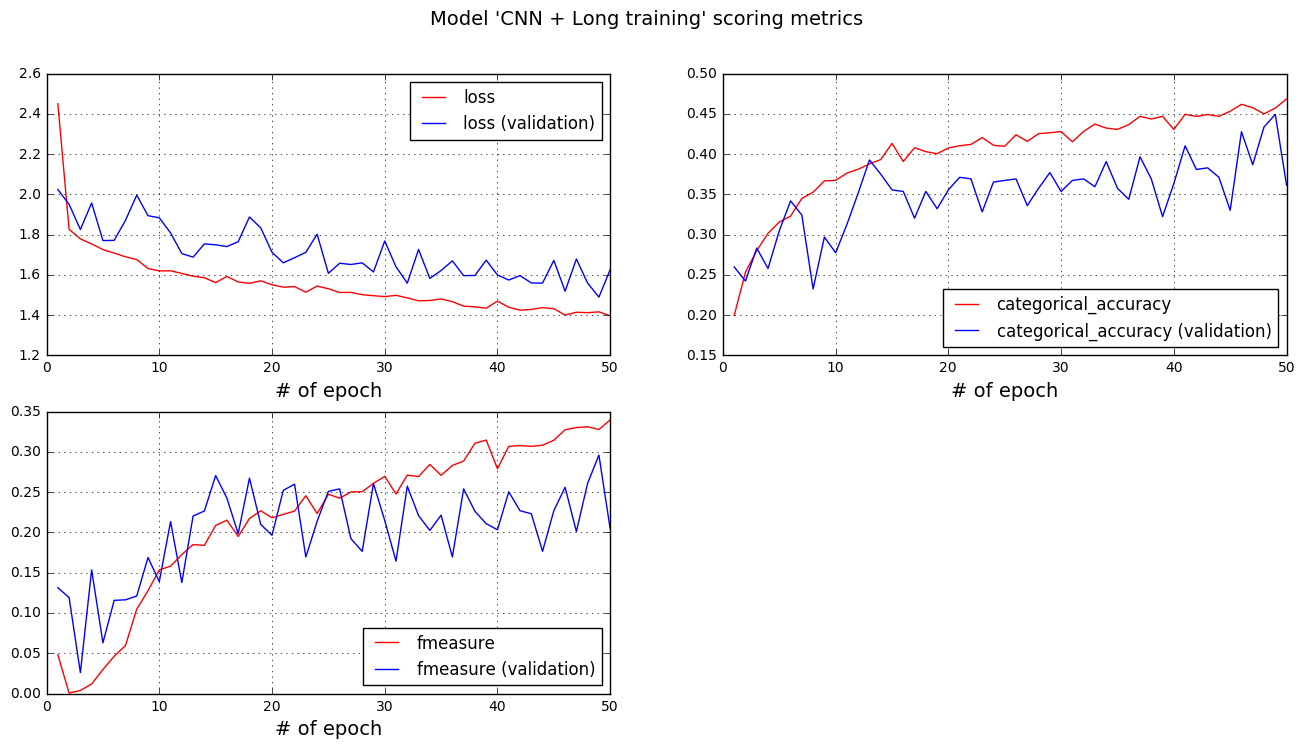

In [71]:
plot_metrics(model.metrics_names, pd.DataFrame(h.history), 'CNN + Long training')

In [74]:
model.save(os.path.join(DATA_FOLDER, 'baseline_cnn_model.h5'))

Now validation results are more clear. There is still some instability in results from epoch to epoch, but there is also some positive trend.

Next step is to try more involed network structure as well as introduce some optimisations into model.

---
### References
[1] Goodfellow, I. J., Shlens, J., and Szegedy, C. (2014b). Explaining and harnessing adver-sarial examples